# Classification with XGBoost and hyperparameter optimization

In [1]:

import os, types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
cos_client = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='H5VwX44tXnkARWHk2iauLMRZH9YjyljTgkQ_gGocI93S',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.private.us.cloud-object-storage.appdomain.cloud')

bucket = 'liverdisease-donotdelete-pr-h7ckmnzqjvmqn4'
object_key = 'indian_liver_patient.csv'

body = cos_client.get_object(Bucket=bucket,Key=object_key)['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()


,Age,Gender,Total_Bilirubin,Direct_Bilirubin,Alkaline_Phosphotase,Alamine_Aminotransferase,Aspartate_Aminotransferase,Total_Protiens,Albumin,Albumin_and_Globulin_Ratio,Dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [2]:
# import required libraries for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
pip install xgboost==1.5.1

Note: you may need to restart the kernel to use updated packages.


In [4]:
# open csv file

df.columns = df.columns.map(str.lower)                              # column names to lowercase
df.head()

,age,gender,total_bilirubin,direct_bilirubin,alkaline_phosphotase,alamine_aminotransferase,aspartate_aminotransferase,total_protiens,albumin,albumin_and_globulin_ratio,dataset
0,65,Female,0.7,0.1,187,16,18,6.8,3.3,0.90,1
1,62,Male,10.9,5.5,699,64,100,7.5,3.2,0.74,1
2,62,Male,7.3,4.1,490,60,68,7.0,3.3,0.89,1
3,58,Male,1.0,0.4,182,14,20,6.8,3.4,1.00,1
4,72,Male,3.9,2.0,195,27,59,7.3,2.4,0.40,1


In [5]:
# check data types, it provides also details on null values, so next checking of null values may not be required
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         583 non-null    int64  
 1   gender                      583 non-null    object 
 2   total_bilirubin             583 non-null    float64
 3   direct_bilirubin            583 non-null    float64
 4   alkaline_phosphotase        583 non-null    int64  
 5   alamine_aminotransferase    583 non-null    int64  
 6   aspartate_aminotransferase  583 non-null    int64  
 7   total_protiens              583 non-null    float64
 8   albumin                     583 non-null    float64
 9   albumin_and_globulin_ratio  579 non-null    float64
 10  dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


In [6]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
age,583.0,NaN,NaN,NaN,44.746141,16.189833,4.0,33.0,45.0,58.0,90.0
gender,583,2,Male,441,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total_bilirubin,583.0,NaN,NaN,NaN,3.298799,6.209522,0.4,0.8,1.0,2.6,75.0
direct_bilirubin,583.0,NaN,NaN,NaN,1.486106,2.808498,0.1,0.2,0.3,1.3,19.7
alkaline_phosphotase,583.0,NaN,NaN,NaN,290.576329,242.937989,63.0,175.5,208.0,298.0,2110.0
alamine_aminotransferase,583.0,NaN,NaN,NaN,80.713551,182.620356,10.0,23.0,35.0,60.5,2000.0
aspartate_aminotransferase,583.0,NaN,NaN,NaN,109.910806,288.918529,10.0,25.0,42.0,87.0,4929.0
total_protiens,583.0,NaN,NaN,NaN,6.48319,1.085451,2.7,5.8,6.6,7.2,9.6
albumin,583.0,NaN,NaN,NaN,3.141852,0.795519,0.9,2.6,3.1,3.8,5.5
albumin_and_globulin_ratio,579.0,NaN,NaN,NaN,0.947064,0.319592,0.3,0.7,0.93,1.1,2.8


### What can we see from describe & info ?
- for gender we have 2 unique values - sounds reasonable
- there seems to be extremes for several fields (compare 75% with max) - we will have to fix it
- dataset, our target variable, has 2 values
- albumin_and_globulin_ratio have some missing values those must be handled

### Handle missing values
We are going to fix missing values on albumin_and_globulin_ratio field, easiest way is often best way, so just replace it with mean or median

In [7]:
# replacing missing values with mean
df.albumin_and_globulin_ratio.fillna(df.albumin_and_globulin_ratio.mean(), inplace=True)

In [8]:
# are there still any missing values?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583 entries, 0 to 582
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   age                         583 non-null    int64  
 1   gender                      583 non-null    object 
 2   total_bilirubin             583 non-null    float64
 3   direct_bilirubin            583 non-null    float64
 4   alkaline_phosphotase        583 non-null    int64  
 5   alamine_aminotransferase    583 non-null    int64  
 6   aspartate_aminotransferase  583 non-null    int64  
 7   total_protiens              583 non-null    float64
 8   albumin                     583 non-null    float64
 9   albumin_and_globulin_ratio  583 non-null    float64
 10  dataset                     583 non-null    int64  
dtypes: float64(5), int64(5), object(1)
memory usage: 50.2+ KB


## Let's start exploratory data analysis (EDA)
Most datascientist will tell you that EDA is most funny part of datascience work. You are exploring different relations between data and how they interact... so do it!

In [9]:
# # correlation between variables
# sns.set()
# sns.pairplot(df, kind='reg')

In [10]:
# # correlation between variables
# sns.set()
# sns.pairplot(df, hue='dataset', kind='reg')

In [11]:
# correlation with dataset - target value
df.corr()['dataset']

age                          -0.137351
total_bilirubin              -0.220208
direct_bilirubin             -0.246046
alkaline_phosphotase         -0.184866
alamine_aminotransferase     -0.163416
aspartate_aminotransferase   -0.151934
total_protiens                0.035008
albumin                       0.161388
albumin_and_globulin_ratio    0.162319
dataset                       1.000000
Name: dataset, dtype: float64

In [12]:
# full correlation table
df.corr().style.background_gradient(cmap='viridis')

,age,total_bilirubin,direct_bilirubin,alkaline_phosphotase,alamine_aminotransferase,aspartate_aminotransferase,total_protiens,albumin,albumin_and_globulin_ratio,dataset
age,1.000000,0.011763,0.007529,0.080425,-0.086883,-0.019910,-0.187461,-0.265924,-0.216089,-0.137351
total_bilirubin,0.011763,1.000000,0.874618,0.206669,0.214065,0.237831,-0.008099,-0.222250,-0.206159,-0.220208
direct_bilirubin,0.007529,0.874618,1.000000,0.234939,0.233894,0.257544,-0.000139,-0.228531,-0.200004,-0.246046
alkaline_phosphotase,0.080425,0.206669,0.234939,1.000000,0.125680,0.167196,-0.028514,-0.165453,-0.233960,-0.184866
alamine_aminotransferase,-0.086883,0.214065,0.233894,0.125680,1.000000,0.791966,-0.042518,-0.029742,-0.002374,-0.163416
aspartate_aminotransferase,-0.019910,0.237831,0.257544,0.167196,0.791966,1.000000,-0.025645,-0.085290,-0.070024,-0.151934
total_protiens,-0.187461,-0.008099,-0.000139,-0.028514,-0.042518,-0.025645,1.000000,0.784053,0.233904,0.035008
albumin,-0.265924,-0.222250,-0.228531,-0.165453,-0.029742,-0.085290,0.784053,1.000000,0.686322,0.161388
albumin_and_globulin_ratio,-0.216089,-0.206159,-0.200004,-0.233960,-0.002374,-0.070024,0.233904,0.686322,1.000000,0.162319
dataset,-0.137351,-0.220208,-0.246046,-0.184866,-0.163416,-0.151934,0.035008,0.161388,0.162319,1.000000


**Outcome?** I've seen in many datasets there is none. Data scientist just simply show correlation and skip any actions to be done... not in this case! 
We have strong correlation between some variables:
- direct_bilirubin & total_bilirubin
- aspartate_aminotransferase & alamine_aminotransferase
- total_protiens & albumin
- albumin_and_globulin_ratio & albumin

We will drop some of them as features should be independent

In [13]:
# this is simply my selection (from highly correlated features, you could also use different from pairs)
df.drop(['direct_bilirubin', 'aspartate_aminotransferase', 'total_protiens', 'albumin'], axis=1, inplace=True)

### Outliers & transformation
Now check data using boxplot and distplot to see what features are skewed, what is ratio of outliers, if log1p helps etc

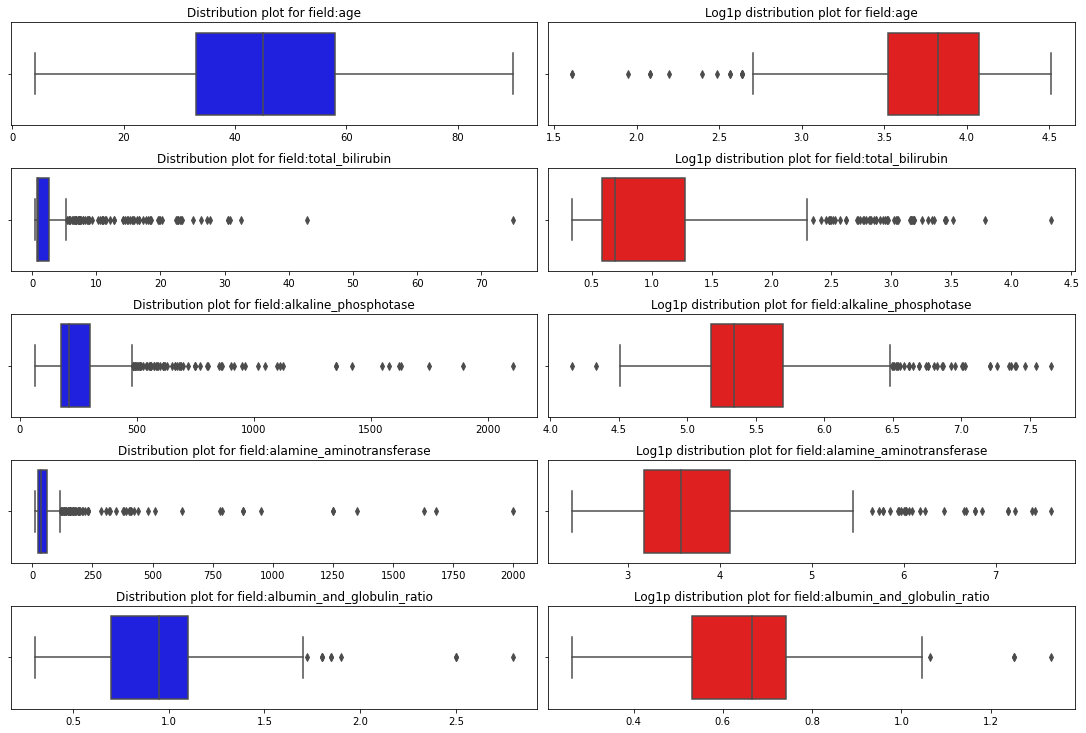

In [14]:
# outlier check
plt.figure(figsize=(15, 20))

for i, c in enumerate(df.drop('dataset', axis=1).select_dtypes(include='number').columns):
    plt.subplot(10,2,i*2+1)
    sns.boxplot(df[c], color='blue')
    plt.title('Distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

    
    plt.subplot(10,2,i*2+2)
    sns.boxplot(df[c].apply('log1p'), color='red')
    plt.title('Log1p distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

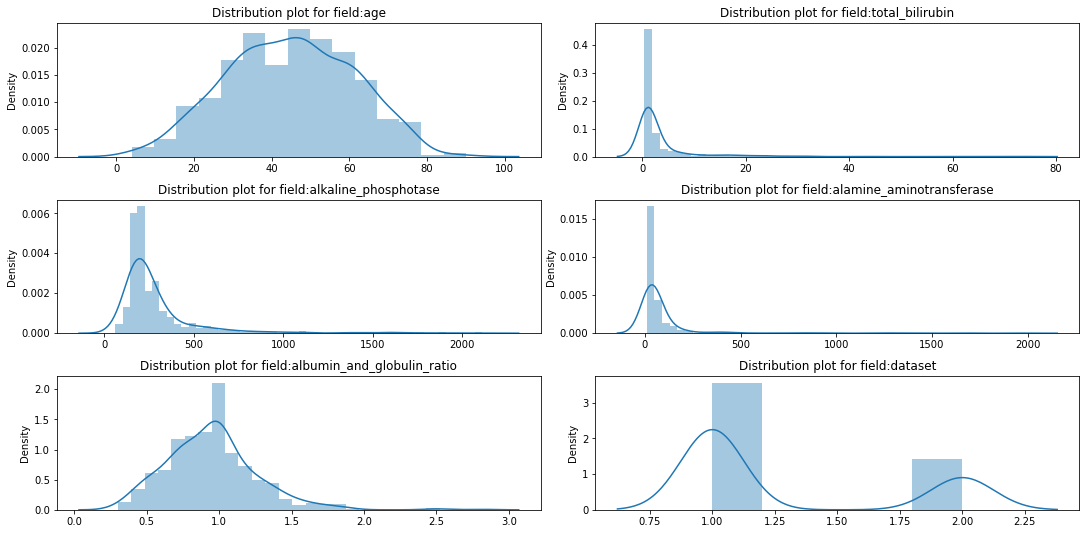

In [15]:
plt.figure(figsize=(15, 12))

for i, c in enumerate(df.select_dtypes(include='number').columns):
    plt.subplot(5,2,i+1)
    sns.distplot(df[c])
    plt.title('Distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)


#### What can we get out of dist plot and box plot?
- dataset is slightly imbalanced
- slightly skewed features: albumin_and_globulin_ration
- strongly skewed features: total_bilirubin, direct_bilirubin, alkaline_phosphotase, alamine_aminotransferase, aspartate_aminotransferase

We will fix these values using log1p transformation and then scale variables using RobustScaler as this one is good for data with outliers. If you think this is not good procedure, let me know!

In [16]:
# save skewed features
skewed_cols = ['albumin_and_globulin_ratio','total_bilirubin', 'alkaline_phosphotase', 'alamine_aminotransferase']

In [17]:
# Apply log1p transformation on dataframe - just selected values
for c in skewed_cols:
    df[c] = df[c].apply('log1p')

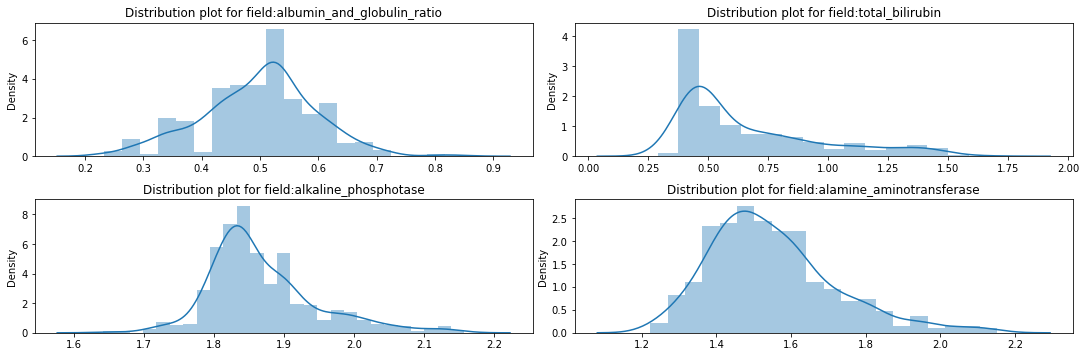

In [18]:
# Next check & fix strongly skewed features
# apply log1p transform
plt.figure(figsize=(15, 12))

for i, c in enumerate(skewed_cols):
    plt.subplot(5,2,i+1)
    sns.distplot(df[c].apply(np.log1p))
    plt.title('Distribution plot for field:' + c)
    plt.xlabel('')
    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

## Encode & Scale
I will use sklearn library to encode gender and scale numerical variables

In [19]:
from sklearn.preprocessing import LabelEncoder, RobustScaler

In [20]:
# gender contains string values Male, Female; these will be converted into 0, 1, as ML algorithms like just numerical values
le = LabelEncoder()
df['gender'] = le.fit_transform(df['gender'])
df.gender.head()

0    0
1    1
2    1
3    1
4    1
Name: gender, dtype: int64

In [21]:
# rs = RobustScaler()
# for c in df[['age', 'gender', 'total_bilirubin', 'alkaline_phosphotase', 'alamine_aminotransferase', 'albumin_and_globulin_ratio']].columns:
#     df[c] = rs.fit_transform(df[c].values.reshape(-1, 1))
# df.head()

## Balance data
As our dataset is imbalanced, will use sklearn's sample to have same ratio of target variables (we could use also SMOTE from imblearn).
This may not be needed each time as some algorithms already have techniques for imbalanced datasets

In [22]:
from sklearn.utils import resample
df.dataset.value_counts()

1    416
2    167
Name: dataset, dtype: int64

In [23]:
# Split data on majority and minority.. minority is dataset == 2
minority = df[df.dataset==2]
majority = df[df.dataset==1]

print('Minority size:', minority.shape)
print('Majority size:', majority.shape)

Minority size: (167, 7)
Majority size: (416, 7)


In [24]:
# choosing upsample as even now we do not have too much data
minority_upsample = resample(minority, replace=True, n_samples=majority.shape[0])
print('Minority upsampled size:', minority_upsample.shape)

Minority upsampled size: (416, 7)


In [25]:
# merge majority with upsampled minority
df = pd.concat([minority_upsample, majority], axis=0)

## Split data for modeling
This is very needed in order to be able to compare performance of model on unseen data. I will choose test size to be 0.25. Dataset is also split to X (features) and y (target) variables.

In [26]:
from sklearn.model_selection import train_test_split
X = (df.drop('dataset', axis=1)).values
y = (df['dataset'] - 1 ).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=123)

print('Train values shape:', X_train.shape)
print('Test values shape:', X_test.shape)
print('Train target shape:', y_train.shape)
print('Test target shape:', y_test.shape)

Train values shape: (624, 6)
Test values shape: (208, 6)
Train target shape: (624,)
Test target shape: (208,)


## Model selection
We will use several popular models and see how they perform on our dataset.
At the end we choose 3 best performing models and will merge them together.

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [28]:
# Logistic Regression
model = LogisticRegression()
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

print(model)
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_test, y_test_hat))


LogisticRegression()
Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.66      0.72       313
           1       0.71      0.83      0.76       311

    accuracy                           0.74       624
   macro avg       0.75      0.74      0.74       624
weighted avg       0.75      0.74      0.74       624

Test performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.47      0.55       103
           1       0.60      0.79      0.68       105

    accuracy                           0.63       208
   macro avg       0.64      0.63      0.62       208
weighted avg       0.64      0.63      0.62       208

Roc_auc score
-------------------------------------------------------
0.6282478039759594

Confusion matrix
-------------------------------------------------------
[[48 55]
 [22 8

Ok, Logistic Regression worked fine, nothing special, but still 0.62 f1 score on test dataset is pretty well, model also does not overfit. But we want better score, let's try now SVM that should work well on low dimension data

In [29]:
# Support Vector Machines
model = SVC()
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

print(model)
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_test, y_test_hat))


SVC()
Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.61      0.68      0.64       313
           1       0.63      0.55      0.59       311

    accuracy                           0.62       624
   macro avg       0.62      0.62      0.62       624
weighted avg       0.62      0.62      0.62       624

Test performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.57      0.61      0.59       103
           1       0.59      0.55      0.57       105

    accuracy                           0.58       208
   macro avg       0.58      0.58      0.58       208
weighted avg       0.58      0.58      0.58       208

Roc_auc score
-------------------------------------------------------
0.5820157189089228

Confusion matrix
-------------------------------------------------------
[[63 40]
 [47 58]]


OK, f1 increased to 0.64, model is not overtrained, even roc_auc is higher so our model is able to do classification better, SVM works fine.... but it's pretty much same as logistic regression, isn't it!? Let's try famous random forest classifier.

In [30]:
# Random Forest
model = RandomForestClassifier(n_jobs=-1,random_state=123)
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

print(model)
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_test, y_test_hat))


RandomForestClassifier(n_jobs=-1, random_state=123)
Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       313
           1       1.00      1.00      1.00       311

    accuracy                           1.00       624
   macro avg       1.00      1.00      1.00       624
weighted avg       1.00      1.00      1.00       624

Test performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.72      0.80       103
           1       0.77      0.91      0.83       105

    accuracy                           0.82       208
   macro avg       0.83      0.82      0.82       208
weighted avg       0.83      0.82      0.82       208

Roc_auc score
-------------------------------------------------------
0.8163661581137309

Confusion matrix
----------------------------------------

Hell yeah! That's why it's so famous, got 0.84 f1 on test dataset, roc_auc reaching 0.85, all looks great just on fact model is overfitting training data... however, still generalize fine on test data.

In [31]:
# Neural nets
model = MLPClassifier()
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

print(model)
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_test, y_test_hat))


MLPClassifier()
Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.79      0.59      0.68       313
           1       0.67      0.84      0.75       311

    accuracy                           0.72       624
   macro avg       0.73      0.72      0.71       624
weighted avg       0.73      0.72      0.71       624

Test performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.43      0.53       103
           1       0.59      0.82      0.69       105

    accuracy                           0.62       208
   macro avg       0.65      0.62      0.61       208
weighted avg       0.65      0.62      0.61       208

Roc_auc score
-------------------------------------------------------
0.6231160425335183

Confusion matrix
-------------------------------------------------------
[[44 59]
 [19 86]]


Not so good as random forest

In [32]:
# K-Neighbors
model = KNeighborsClassifier()
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)
print(model)
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_test, y_test_hat))


KNeighborsClassifier()
Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.90      0.75      0.82       313
           1       0.79      0.92      0.85       311

    accuracy                           0.83       624
   macro avg       0.84      0.84      0.83       624
weighted avg       0.84      0.83      0.83       624

Test performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.70      0.54      0.61       103
           1       0.63      0.77      0.70       105

    accuracy                           0.66       208
   macro avg       0.67      0.66      0.65       208
weighted avg       0.67      0.66      0.65       208

Roc_auc score
-------------------------------------------------------
0.6575589459084604

Confusion matrix
-------------------------------------------------------
[[56 47]
 [24

Also not so good

... which one is most favorite machine learning model on Kaggle? XGBoost! ... let's try it, unfortunately it's not part of sklearn so must be installed separately (or is, but in slightly modified version)

In [ ]:
from xgboost import XGBClassifier

model = XGBClassifier(random_state=123,eval_metric='logloss')
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

print(model)
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_test, y_test_hat))


Nice one, XGBoost is catching random forest in performance!

In [35]:
# Extra Trees
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier(random_state=123)
model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

print(model)
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_test, y_test_hat))


ExtraTreesClassifier(random_state=123)
Train performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       313
           1       1.00      1.00      1.00       311

    accuracy                           1.00       624
   macro avg       1.00      1.00      1.00       624
weighted avg       1.00      1.00      1.00       624

Test performance
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.81      0.84       103
           1       0.82      0.89      0.85       105

    accuracy                           0.85       208
   macro avg       0.85      0.85      0.85       208
weighted avg       0.85      0.85      0.85       208

Roc_auc score
-------------------------------------------------------
0.8457697642163661

Confusion matrix
-----------------------------------------------------

Incredible! Extra Trees has definitely best performance from all models we've tried:
- 86% precission
- 86% recall
- 0.86 f1
- 0.85 roc_auc

## Model evaluation & optimization
As our dataset is not too big, we will use GridSearchCV for parameter tuning, in case of large datasets RandomizedSearchCV could be better. Our main objective will be to improve roc_auc score and avoid overfitting

In [36]:
from sklearn.model_selection import GridSearchCV, KFold

In [37]:
# # Random forest
# # n_jobs=-1 to allow run it on all cores
# params = {
#     'n_estimators': [100, 200, 500],
#     'criterion': ['gini', 'entropy'],
#     'min_samples_split': [1,2,4,5],
#     'min_samples_leaf': [1,2,4,5],
#     'max_leaf_nodes': [4,10,20,50,None]
# }

# gs1 = GridSearchCV(RandomForestClassifier(), params, cv=KFold(n_splits=3), scoring='roc_auc')
# gs1.fit(X_train, y_train)

# print('Best score:', gs1.best_score_)
# print('Best score:', gs1.best_params_)


In [38]:
# # XGBoost
# # n_jobs=-1 to allow run it on all cores
# params = {
#     'n_estimators': [100, 200, 500],
#     'learning_rate': [0.01,0.05,0.1],
#     'booster': ['gbtree', 'gblinear'],
#     'gamma': [0, 0.5, 1],
#     'reg_alpha': [0, 0.5, 1],
#     'reg_lambda': [0.5, 1, 5],
#     'base_score': [0.2, 0.5, 1]
# }

# gs2 = GridSearchCV(XGBClassifier(), params, cv=KFold(n_splits=3), scoring='roc_auc')
# gs2.fit(X_train, y_train)

# print('Best score:', gs2.best_score_)
# print('Best score:', gs2.best_params_)

In [39]:
# # Extra Tree
# # n_jobs=-1 to allow run it on all cores
# params = {
#     'n_estimators': [100, 200, 500],
#     'criterion': ['gini', 'entropy'],
#     'min_samples_split': [1,2,4,5],
#     'min_samples_leaf': [1,2,4,5],
#     'max_leaf_nodes': [4,10,20,50,None]
# }

# gs3 = GridSearchCV(ExtraTreesClassifier(), params, cv=KFold(n_splits=3), scoring='roc_auc')
# gs3.fit(X_train, y_train)

# print('Best score:', gs3.best_score_)
# print('Best score:', gs3.best_params_)

## Voting - we will use these 3 models in final, merge them
Objective here is not to make more accurate model (but it can be), however we want to more stable model

In [40]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier

votes = [
    ('rf', RandomForestClassifier(n_jobs=-1, criterion='gini', max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100)),
    ('xgb', XGBClassifier(n_jobs=-1, base_score=0.2, booster='gbtree', gamma=0, learning_rate=0.1, n_estimators=500, reg_alpha=0, reg_lambda=1)),
    ('xt', ExtraTreesClassifier(n_jobs=-1, criterion='gini', max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500))
]

# votes = [
#     ('rf', gs1.best_estimator_),
#     ('xgb', gs2.best_estimator_),
#     ('xt', gs3.best_estimator_)
# ]

# soft voting based on weights
votesClass = VotingClassifier(estimators=votes, voting='soft', n_jobs=-1)
votesClass_cv = cross_validate(votesClass, X_train, y_train, cv=KFold(3))
votesClass.fit(X_train, y_train)

votesClass_cv

/opt/conda/envs/Python-3.9/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


KeyboardInterrupt: 

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

model = votesClass
#model.fit(X_train, y_train)
y_train_hat = model.predict(X_train)
y_test_hat = model.predict(X_test)

print(model)
print('Train performance')
print('-------------------------------------------------------')
print(classification_report(y_train, y_train_hat))

print('Test performance')
print('-------------------------------------------------------')
print(classification_report(y_test, y_test_hat))

print('Roc_auc score')
print('-------------------------------------------------------')
print(roc_auc_score(y_test, y_test_hat))
print('')

print('Confusion matrix')
print('-------------------------------------------------------')
print(confusion_matrix(y_test, y_test_hat))


In [ ]:
model.predict([[-0.2       , -1.        , -0.07400058,  0.64736905,  1.98471644,
        -0.37166352]])

In [ ]:
X_test

In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import VotingClassifier

votes = [
    ('rf', RandomForestClassifier(n_jobs=-1, criterion='gini', max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100)),
    ('xgb', XGBClassifier(n_jobs=-1, base_score=0.2, booster='gbtree', gamma=0, learning_rate=0.1, n_estimators=500, reg_alpha=0, reg_lambda=1)),
    ('xt', ExtraTreesClassifier(n_jobs=-1, criterion='gini', max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2, n_estimators=500))
]

# votes = [
#     ('rf', gs1.best_estimator_),
#     ('xgb', gs2.best_estimator_),
#     ('xt', gs3.best_estimator_)
# ]

# soft voting based on weights
votesClass = VotingClassifier(estimators=votes, voting='soft', n_jobs=-1)
votesClass_cv = cross_validate(votesClass, X, y, cv=KFold(3))
votesClass.fit(X, y)

votesClass_cv

**Great**, we've got f1 score 0.84, it's not better that we've had, but even not worse.
Our model is still overfitting data, it could be much better having more data but model still generalize well on test set.
If you have any suggestions how to reduce overfitting, place your comment here ;)

# IBM DEPLOYMENT

In [42]:
!pip install -U ibm-watson-machine-learning

In [43]:
from ibm_watson_machine_learning import APIClient
import json

# AUTHENTICATE AND SET SPACE

In [45]:
wml_credentials ={
    "apikey":"j0BgO8c07rllOiKYd-fzN6fUKss9_b9Sd633gGNKCTgx",
    "url":"https://us-south.ml.cloud.ibm.com"
}

In [46]:
wml_client = APIClient(wml_credentials)

In [47]:
wml_client.spaces.list()

Note: 'limit' is not provided. Only first 50 records will be displayed if the number of records exceed 50
------------------------------------  -----  ------------------------
ID                                    NAME   CREATED
16f09ae2-fea1-43c5-beb7-b9cde7c7398b  liver  2022-11-14T12:59:25.162Z
fb3f439f-11b4-4c30-9aeb-d794ed108bca  uaep   2022-11-13T07:14:36.279Z
------------------------------------  -----  ------------------------


In [48]:
SPACE_ID="16f09ae2-fea1-43c5-beb7-b9cde7c7398b"

In [49]:
wml_client.set.default_space(SPACE_ID)

'SUCCESS'

In [50]:
wml_client.software_specifications.list(500)

-------------------------------  ------------------------------------  ----
NAME                             ASSET_ID                              TYPE
default_py3.6                    0062b8c9-8b7d-44a0-a9b9-46c416adcbd9  base
kernel-spark3.2-scala2.12        020d69ce-7ac1-5e68-ac1a-31189867356a  base
pytorch-onnx_1.3-py3.7-edt       069ea134-3346-5748-b513-49120e15d288  base
scikit-learn_0.20-py3.6          09c5a1d0-9c1e-4473-a344-eb7b665ff687  base
spark-mllib_3.0-scala_2.12       09f4cff0-90a7-5899-b9ed-1ef348aebdee  base
pytorch-onnx_rt22.1-py3.9        0b848dd4-e681-5599-be41-b5f6fccc6471  base
ai-function_0.1-py3.6            0cdb0f1e-5376-4f4d-92dd-da3b69aa9bda  base
shiny-r3.6                       0e6e79df-875e-4f24-8ae9-62dcc2148306  base
tensorflow_2.4-py3.7-horovod     1092590a-307d-563d-9b62-4eb7d64b3f22  base
pytorch_1.1-py3.6                10ac12d6-6b30-4ccd-8392-3e922c096a92  base
tensorflow_1.15-py3.6-ddl        111e41b3-de2d-5422-a4d6-bf776828c4b7  base
autoai-kb_rt

# SAVE AND DEPLOY MODEL

In [51]:
import sklearn
sklearn.__version__

'1.0.2'

In [52]:
MODEL_NAME = 'xgboost_classifier_and_hyperparameter_tuning_85 (1)'
DEPLOYMENT_NAME = 'liver'
DEMO_MODEL = model

In [53]:
# Set Python Version
software_spec_uid = wml_client.software_specifications.get_id_by_name('runtime-22.1-py3.9')

In [54]:
# Setup model meta
model_props = {
    wml_client.repository.ModelMetaNames.NAME: MODEL_NAME, 
    wml_client.repository.ModelMetaNames.TYPE: 'scikit-learn_1.0', 
    wml_client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: software_spec_uid 
}

In [55]:
#Save model
model_details = wml_client.repository.store_model(
    model=DEMO_MODEL, 
    meta_props=model_props, 
    training_data=X_train, 
    training_target=y_train
)

In [56]:
model_details

{'entity': {'hybrid_pipeline_software_specs': [],
  'label_column': 'l1',
  'schemas': {'input': [{'fields': [{'name': 'f0', 'type': 'float'},
      {'name': 'f1', 'type': 'float'},
      {'name': 'f2', 'type': 'float'},
      {'name': 'f3', 'type': 'float'},
      {'name': 'f4', 'type': 'float'},
      {'name': 'f5', 'type': 'float'}],
     'id': '1',
     'type': 'struct'}],
   'output': []},
  'software_spec': {'id': '12b83a17-24d8-5082-900f-0ab31fbfd3cb',
   'name': 'runtime-22.1-py3.9'},
  'type': 'scikit-learn_1.0'},
 'metadata': {'created_at': '2022-11-14T13:20:46.435Z',
  'id': '3902c88a-7906-46a6-877b-a74cc91782a7',
  'modified_at': '2022-11-14T13:20:52.836Z',
  'name': 'xgboost_classifier_and_hyperparameter_tuning_85 (1)',
  'owner': 'IBMid-667000D40I',
  'resource_key': '39d6714a-705a-4570-825b-c5495d01a815',
  'space_id': '16f09ae2-fea1-43c5-beb7-b9cde7c7398b'},
 'system': {'warnings': []}}

In [57]:
model_id = wml_client.repository.get_model_id(model_details)
model_id

'3902c88a-7906-46a6-877b-a74cc91782a7'

In [58]:
# Set meta
deployment_props = {
    wml_client.deployments.ConfigurationMetaNames.NAME:DEPLOYMENT_NAME, 
    wml_client.deployments.ConfigurationMetaNames.ONLINE: {}
}

In [59]:
# Deploy
deployment = wml_client.deployments.create(
    artifact_uid=model_id, 
    meta_props=deployment_props 
)



#######################################################################################

Synchronous deployment creation for uid: '3902c88a-7906-46a6-877b-a74cc91782a7' started

#######################################################################################


initializing
Note: online_url is deprecated and will be removed in a future release. Use serving_urls instead.

ready


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='61158191-4047-4d6d-ae8a-b137b0c8c2d2'
------------------------------------------------------------------------------------------------




## Conclusion
In this kernel I've tried to present basic work of data scientist. As I am just starting, excuse possible mistakes and propose better solutions in comment section.

This is my **very first kernel on kaggle**, give me thumb up if you enjoyed at least a bit ;)